### 1) Imports

In [43]:
#==========================================================
#                       Imports
#==========================================================
from __future__ import division

import os, sys, time
import h5py as hp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv

import NAFFlib as pnf

# Added by Themis
import scipy
#sys.path.append('/Applications/anaconda/pkgs/')
#sys.path.append('/nfsbigdata1/tmastorigrp/src/')

from scipy.constants import m_p, c, e
from mpl_toolkits.mplot3d import Axes3D

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss 
from PyHEADTAIL.trackers.detuners import Chromaticity, AmplitudeDetuning
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import RFSystems, LinearMap
from PyHEADTAIL.monitors.monitors import BunchMonitor, SliceMonitor, ParticleMonitor
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.impedances.wakes import CircularResonator, WakeTable, WakeField


sys.path.append('../../utils')
from coordinatesConversions import *
from cmpt_TuneSpreads import *

%matplotlib inline

In [44]:
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize': 7,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [45]:
plt.close('all')

## 2) Study parameters

In [46]:
#==========================================================
#           Variables We (Usually) Do Not Change
#==========================================================

gamma = 287.8
p0 = m_p*c*np.sqrt(gamma**2 - 1)
beta = np.sqrt(1 - 1/gamma**2)
circumference = 6911.5623
frev = 299792458/circumference


# PARAMETERS FOR TRANSVERSE MAP
# =====================
n_segments = 1
s = np.arange(0, n_segments+1)*circumference/n_segments
# optics at CC2
alpha_x = 0 * np.ones(n_segments)  # -0.9120242128
beta_x = 30.31164764 * np.ones(n_segments)
D_x = 0 * np.ones(n_segments) # -0.4954033073
alpha_y = 0 * np.ones(n_segments)  # 1.862209583
beta_y = 73.81671646 * np.ones(n_segments)
D_y = 0 * np.ones(n_segments)


Q_x, Q_y = 26.13, 26.18
Qp_x, Qp_y = 0.5, 0.5 #10

# detuning coefficients in (1/m)
app_x = 153.8183853  #2.4705e-15 #4e-11
app_xy = -416.0175086  #-0*2.25e-11
app_y = -50.03699877 #-7.31-14 #0*3e-11

# PARAMETERS FOR LONGITUDINAL MAP
# =======================
alpha = 1.9e-3
Q_s = 0.0051
h1, h2 = 4620, 9240
V1, V2 = 5.008e6, 0e6
dphi1, dphi2 = 0, np.pi
p_increment = 0 * e/c * circumference/(beta*c)


# CREATE BEAM
# ===========
macroparticlenumber = int(900) # at least 5e5 particles are needed in the presence of the wakefields

charge = e
mass = m_p

R = circumference/(2*np.pi)
eta = alpha-1/gamma**2
beta_z = np.abs(eta)*R/Q_s


epsn_x = 2e-6
epsn_y = 2e-6     
epsn_z    = 2.5
sigma_z   = 0.155 #2*0.0755

sigma_x = np.sqrt(epsn_x/(beta*gamma) * beta_x[0])
sigma_xp = sigma_x/beta_x[0]
sigma_y = np.sqrt(epsn_y/(beta*gamma) * beta_y[0])
sigma_yp = sigma_y/beta_y[0]
sigma_dp = sigma_z/beta_z
epsn_z = 4*np.pi * p0/e * sigma_z*sigma_dp

intensity = 3.5e10


In [47]:
# GENERATE BUNCH - grid equally spaced in Jx and Jy up to 3 sigma
# ==================

bunch = generate_Gaussian6DTwiss(macroparticlenumber, intensity, charge, mass, circumference, gamma, alpha_x[0], alpha_y[0], beta_x[0], beta_y[0], beta_z, epsn_x, epsn_y, epsn_z)

# Switch to action angle coordinates
x_n, xp_n = cmpt_normalised_coordinates(bunch.x, bunch.xp, beta_x[0], alpha_x[0])
y_n, yp_n = cmpt_normalised_coordinates(bunch.y, bunch.yp, beta_y[0], alpha_y[0])


Jx, Jy = cmpt_actions(x_n, xp_n), cmpt_actions(y_n, yp_n)
Jx_std, Jy_std = np.std(Jx), np.std(Jy)


print(3*Jx_std, 3*Jy_std)
# Create the initial condition
steps = int(np.sqrt(macroparticlenumber))
J_min = 10**(-12)
Jx_max = 3*Jx_std
Jy_max = 3*Jy_std

Jx = np.linspace(J_min, Jx_max, steps)
Jy = np.linspace(J_min, Jy_max, steps)

# Go back to cartesian coordinates. For px and py =0 
x = np.sqrt(Jx*beta_x[0]*2)
y = np.sqrt(Jy*beta_y[0]*2)

# meshgrid
xx, yy = np.meshgrid(x, y)


bunch.x = xx.flatten()
bunch.y = yy.flatten()


bunch.xp = 0 * np.ones(macroparticlenumber)
bunch.yp = 0 * np.ones(macroparticlenumber)
bunch.z = 0 * np.ones(macroparticlenumber)
bunch.dp = 0 * np.ones(macroparticlenumber)




2.126363385454921e-08 2.198405578430589e-08


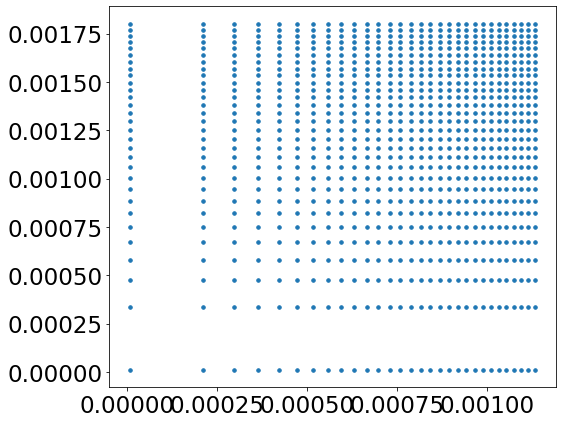

In [48]:
plt.plot(bunch.x , bunch.y,  '.')

In [49]:
# Switch to action angle coordinates
x_n, xp_n = cmpt_normalised_coordinates(bunch.x, bunch.xp, beta_x[0], alpha_x[0])
y_n, yp_n = cmpt_normalised_coordinates(bunch.y, bunch.yp, beta_y[0], alpha_y[0])


Jx, Jy = cmpt_actions(x_n, xp_n), cmpt_actions(y_n, yp_n)

In [50]:
Qx_incoherent_analytical = amplitude_detuning_x(Jx, Jy, app_x, app_xy)
Qy_incoherent_analytical = amplitude_detuning_y(Jx, Jy, app_y, app_xy)
print(len(Qy_incoherent_analytical))

900


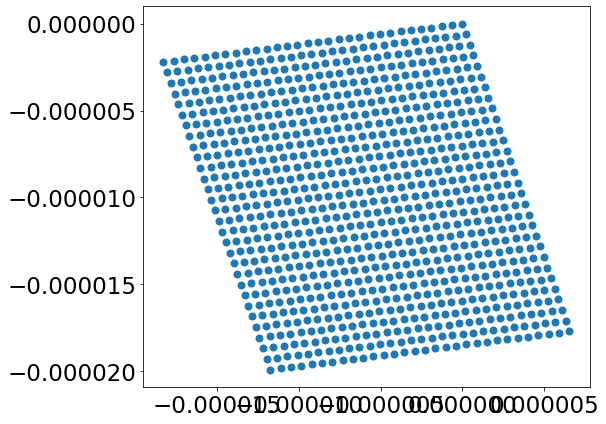

In [51]:
plt.plot(Qx_incoherent_analytical, Qy_incoherent_analytical, 'o')

### Apply condition for realistic position of particles.

The probability of particles to have very large Jx and Jy at the same time is very small (botthom left corner).
Thus we apply the following condition:

\begin{equation}
\frac{Jx}{Jx_{max}} + \frac{Jy}{Jy_{max}} \geq 1
\end{equation}

Using this condition we should obtain the familiar triangular footprint.

In [58]:
Jx_max, Jy_max = np.max(Jx), np.max(Jy)
print(Jx_max, Jy_max)

2.126363385454921e-08 2.1984055784305897e-08


In [59]:
Qx_list, Qy_list=[], []
Qx_list_2, Qy_list_2=[], [] 
for particle in range(macroparticlenumber):
    condition = Jx[particle]/Jx_max + Jy[particle]/Jy_max 
    if condition < 1 :
        Qx_list.append(amplitude_detuning_x(Jx[particle], Jy[particle], app_x, app_xy))
        Qy_list.append(amplitude_detuning_y(Jx[particle], Jy[particle], app_y, app_xy))
    else:
        Qx_list_2.append(amplitude_detuning_x(Jx[particle], Jy[particle], app_x, app_xy))
        Qy_list_2.append(amplitude_detuning_y(Jx[particle], Jy[particle], app_y, app_xy))

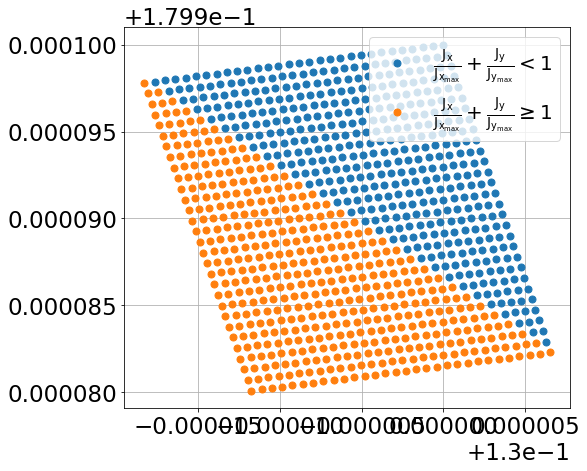

In [67]:
plt.plot(0.13+np.array(Qx_list), 0.18+np.array(Qy_list), 'o', label=r'$\mathrm{\frac{J_x}{J_{x_{max}}}+\frac{J_y}{J_{y_{max}}}} < 1 $')
plt.plot(0.13+np.array(Qx_list_2), 0.18+np.array(Qy_list_2), 'o', label=r'$\mathrm{\frac{J_x}{J_{x_{max}}}+\frac{J_y}{J_{y_{max}}}} \geq 1 $')
plt.legend()
plt.grid()

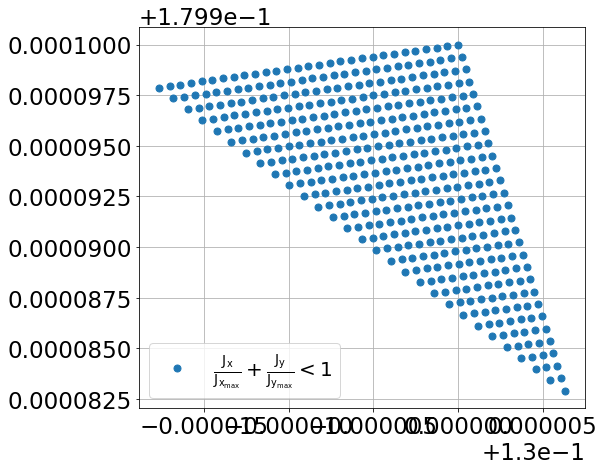

In [68]:
plt.plot(0.13+np.array(Qx_list), 0.18+np.array(Qy_list), 'o', label=r'$\mathrm{\frac{J_x}{J_{x_{max}}}+\frac{J_y}{J_{y_{max}}}} < 1 $')
plt.legend()
plt.grid()